# Classifiez automatiquement des biens de consommation
## Notebook 3 : Faisabilité de classification d'images via CNN
OpenClassrooms - Parcours Data Scientist - Projet 06  

## Présentation du projet

**Contexte**  


* **Place de marché** souhaite lancer une marketplace e-commerce anglophone  
* Les vendeurs proposent des articles à des acheteurs en postant une photo et une description  
* Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, elle est peu fiable. Le volume des articles est très petit  
* Il devient nécessaire d'**automatiser la tâche d‘attribution de la catégorie**

**Missions**  
* Étude de faisabilité à partir de données texte (Notebook 1)  
* Étude de faisabilité à partir des images - SIFT (Notebook 2)  
* **Étude de faisabilité à partir des images - CNN** (ce notebook)  
* Collecte de produits à partie d'une API (Notebook 4)

**Étude de faisabilité à partir des images via CNN**  
* **CNN** : **C**onvolutional **N**eural **N**etworks = Réseaux de Neurones Convolutifs
* CNN à tester :  
   * Modèle simple (4 couches de convolution), qui servira de base de référence  
   * VGG16 pour bénéficier du transfer learning  
   * VGG16 avec data augmentation

**Étapes**  
* Prétraitement commun des images  
* Pour chaque modèle :
* Récupération des features
* KMeans + t-SNE

## Sommaire  
**Préparation de l'environnement**  
* Environnement virtuel
* Import des modules
* Fonctions
* Chargement du dataset  

# 1 Préparation de l'environnement

## 1.1 Environnement virtuel

In [1]:
# Vérification environnement virtuel
envs = !conda env list
print(f"Environnement virtuel : {[e for e in envs if '*' in e][0].split('*')[1].strip()}")

Environnement virtuel : C:\Users\chrab\anaconda3\envs\opc6_3


## 1.2 Import des modules

* Installation conditionnelle des librairies

In [2]:
import sys
import subprocess
import pkg_resources

def install_package(package):
    """Installe une librairie en mode silencieux si elle n'est pas encore installée"""
    try:
        pkg_resources.get_distribution(package)
    except pkg_resources.DistributionNotFound:
        print(f"Installation {package}... ", end='')
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        print(f"Terminé.")
    else:
        print(f"{package} est déjà installé.")

In [3]:
# Installation des librairies
install_package('numpy')
install_package('pandas')
install_package('matplotlib')
install_package('seaborn')
install_package('tensorflow')
install_package('scikit-learn')
install_package('pillow')

numpy est déjà installé.
pandas est déjà installé.
matplotlib est déjà installé.
seaborn est déjà installé.
tensorflow est déjà installé.
scikit-learn est déjà installé.
pillow est déjà installé.


* Import des modules

In [4]:
# Import des modules
import os
import time
import warnings
import shutil
import random

from PIL import Image

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

* Paramétrages

In [5]:
# FAST_MODE = False # Force l'exécution du code concerné, et écrase les fichiers s'ils existent
FAST_MODE = True

In [6]:
# Nombre de coeurs disponibles
print(os.cpu_count())

16


In [7]:
# Nombre de coeurs à utiliser
NUM_CORES = 8

# 2 Préparation des données

## 2.1 Chargement du dataset

In [8]:
# Conversion du fichier csv en DataFrame
df_datas = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [9]:
# Affichage de quelques lignes avec les features clés
display(df_datas[['image', 'product_category_tree']].head(3))

image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   

                               product_category_tree  
0  ["Home Furnishing >> Curtains & Accessories >>...  
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...

## 2.2 Création des labels des images

* Création d'un DataFrame avec :
    * nom du fichier image (`image`)  
    * nom de la catégorie (`label_name`)  
    * numéro de la catégorie (`label`)

In [10]:
# Récupération des noms de catégories principales
df_datas['label_name'] = df_datas['product_category_tree'].apply(lambda x: x.split('["')[1].split(' >>')[0])

# Encodage des labels
# category_label_encoder = LabelEncoder()
# df_datas['label'] = category_label_encoder.fit_transform(df_datas['label_name'])

# Suppression des colonnes inutilisées
# df_datas = df_datas[['image', 'label_name', 'label']]
df_datas = df_datas[['image', 'label_name']]

In [11]:
display(df_datas)

image       label_name
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing
1     7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care
2     64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care
3     d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing
4     6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing
...                                    ...              ...
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg        Baby Care
1046  fd6cbcc22efb6b761bd564c28928483c.jpg        Baby Care
1047  5912e037d12774bb73a2048f35a00009.jpg        Baby Care
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg        Baby Care
1049  f2f027ad6a6df617c9f125173da71e44.jpg        Baby Care

[1050 rows x 2 columns]

In [12]:
df_datas.groupby('label_name').count()

image
label_name                       
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150

## 2.3 Affichage des images par catégories

In [13]:
# Répertoire où se trouvent les fichiers images
image_path = './images/'

Catégorie : Home Furnishing


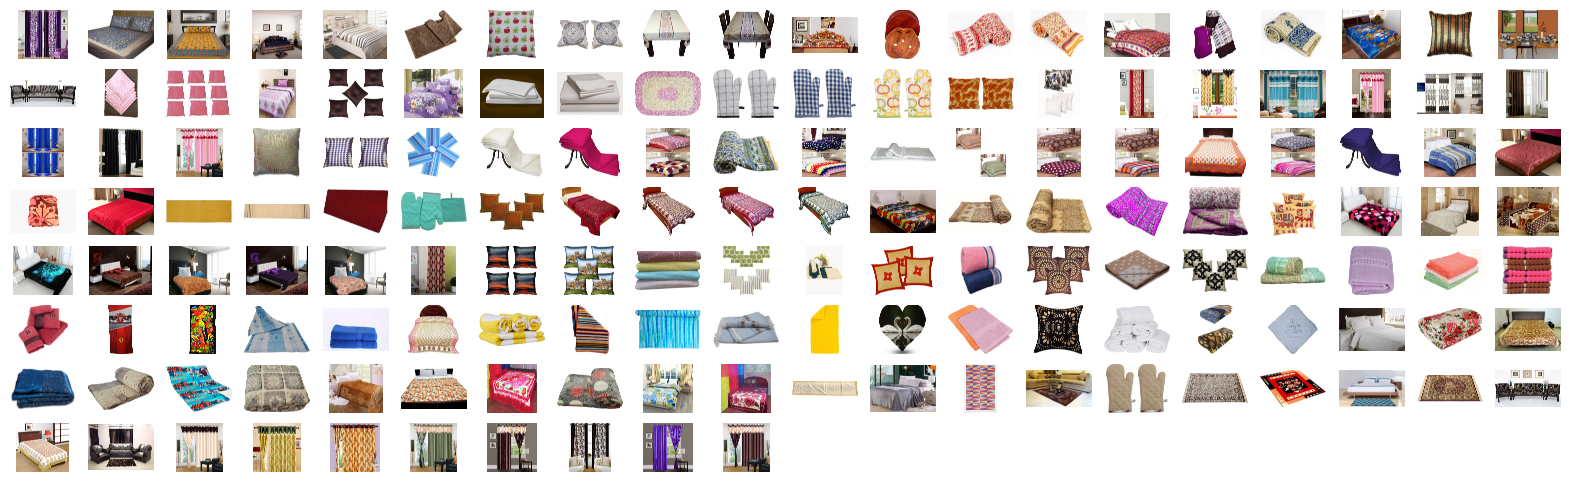


Catégorie : Baby Care


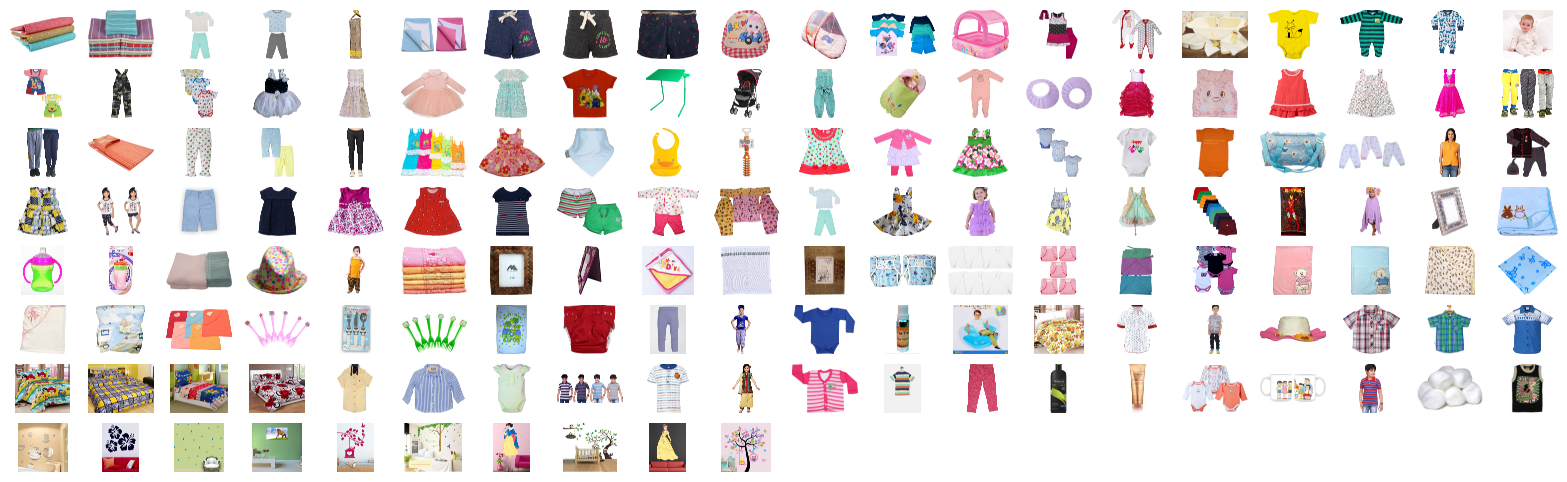


Catégorie : Watches


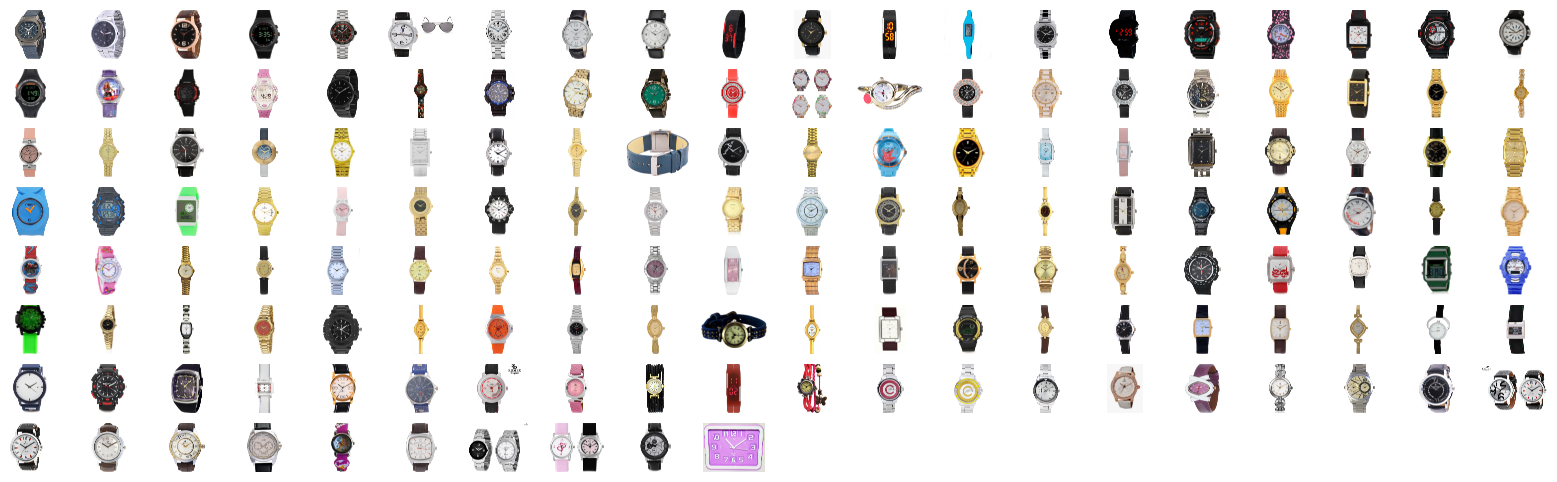


Catégorie : Home Decor & Festive Needs


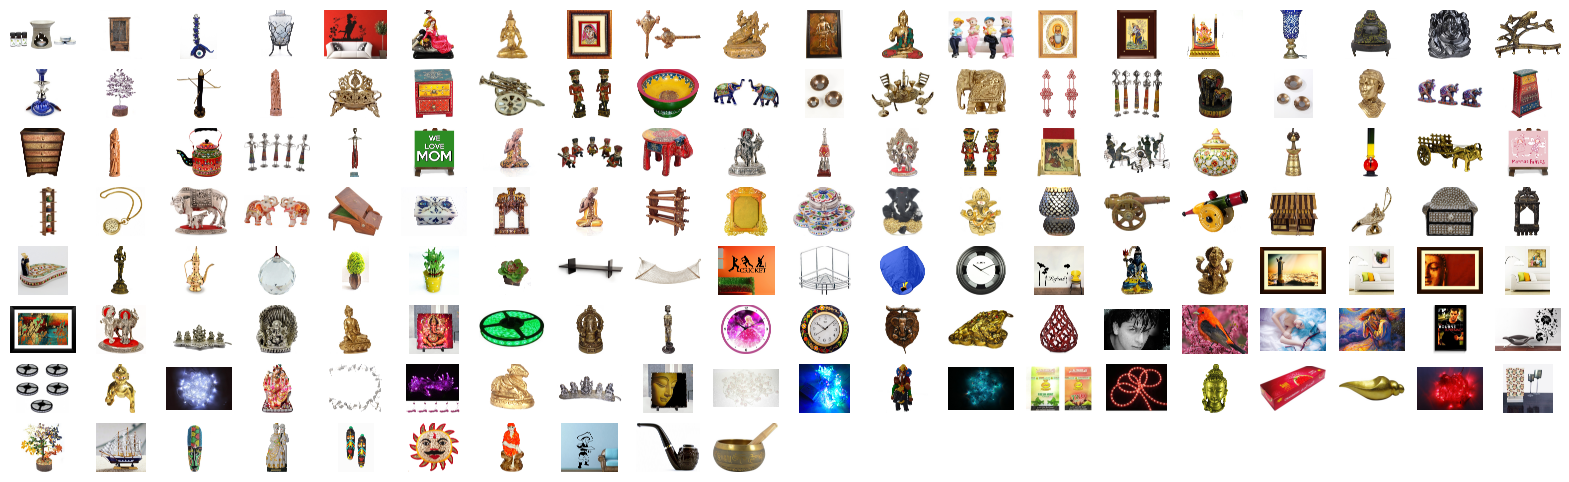


Catégorie : Kitchen & Dining


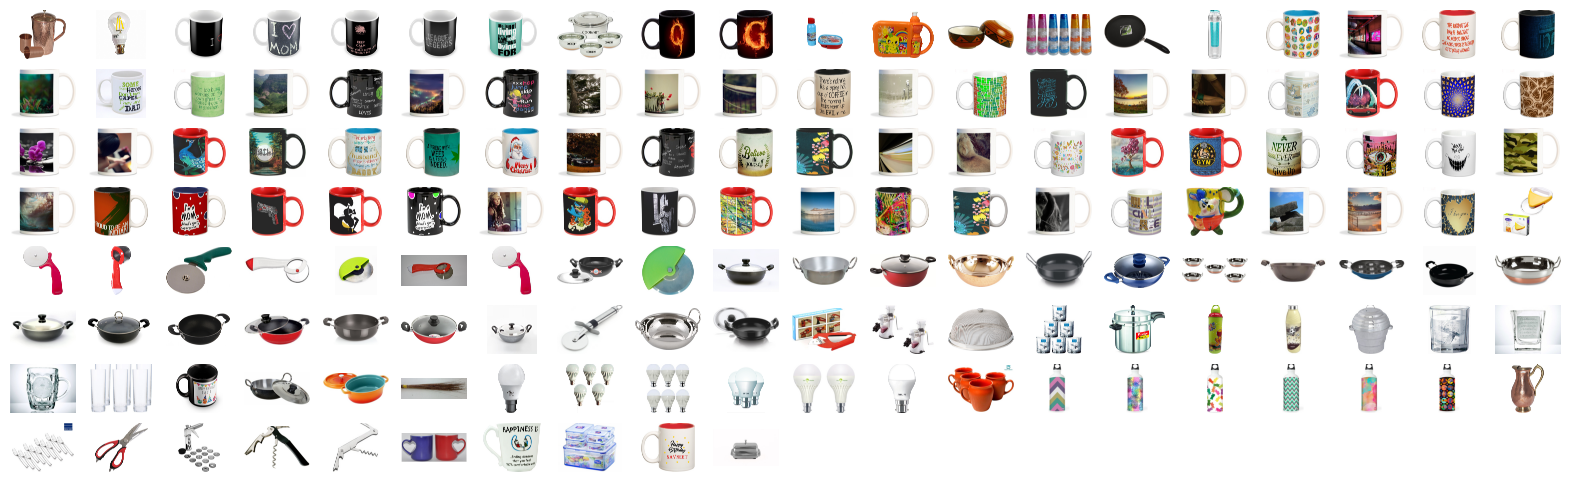


Catégorie : Beauty and Personal Care


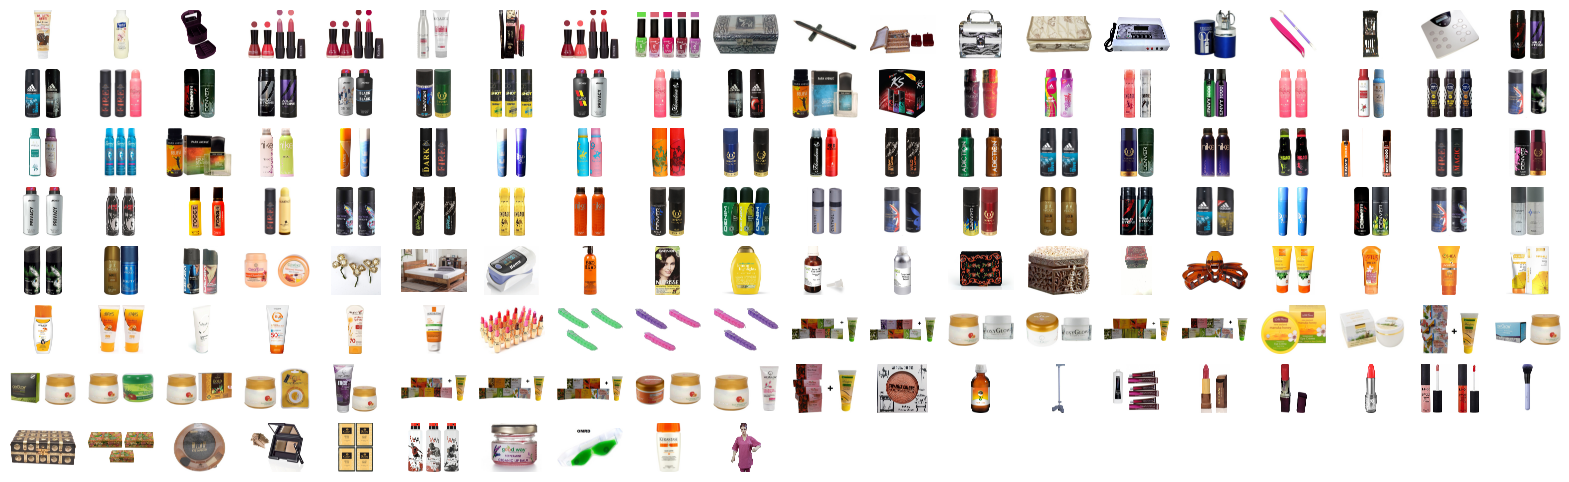


Catégorie : Computers


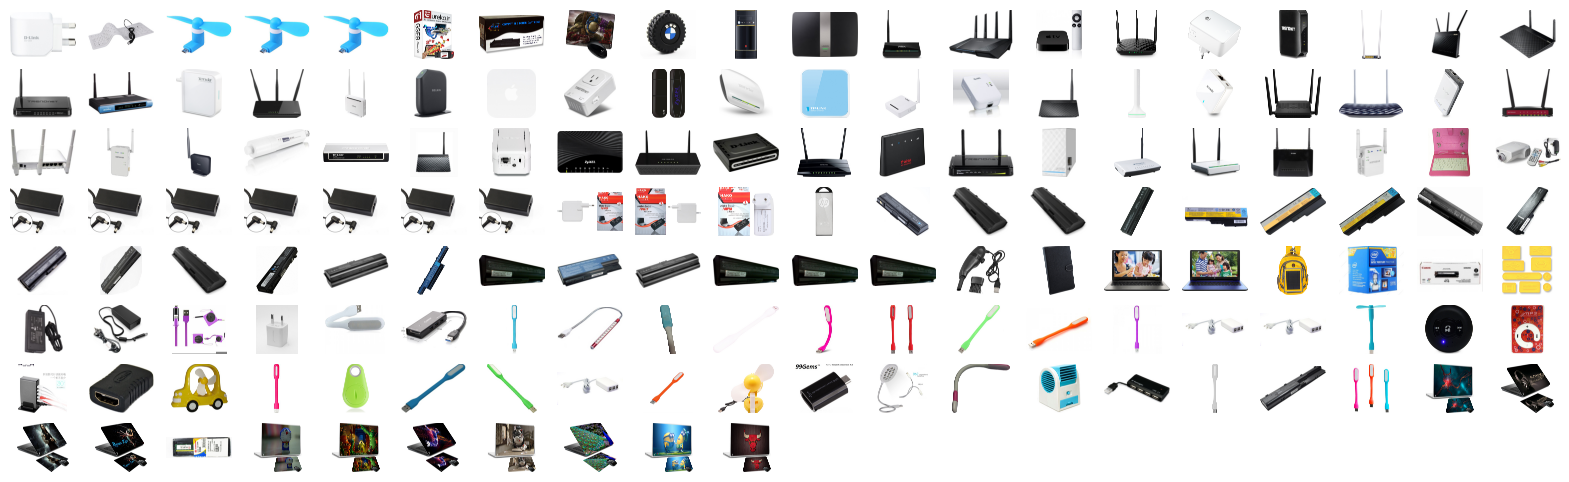

In [14]:
# Suppression de la limite de taille des images
Image.MAX_IMAGE_PIXELS = None

# Affichage des 150 images de chaque catégorie
for category in df_datas['label_name'].unique():
    mask = df_datas['label_name'] == category
    images = df_datas.loc[mask, 'image'].values
    print(f"Catégorie : {category}")
    plt.figure(figsize=(20, 6))
    for i in range(150):
        plt.subplot(8, 20, i + 1)
        filename = image_path + images[i]
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off')
    plt.show()
    print()

## 2.4 Préparation du prétraitement des images

Pour obtenir des résultats comparables, le choix est fait de s'aligner sur les prétraitements demandés pas le modèle VGG16, à savoir :  
* Images au format RGB
* Images de taille 224 x 224
* Normalisation consistant diviser la valeur de chaque pixel par 255  

* Fonction de prétraitement

In [15]:
def preprocess_images(df, image_path):
    """
    Prétraite les images pour alimenter les modèles CNN en les convertisant
    au format RGB, les redimensionnant en 224x224 pixels, en normalisant la
    valeur des pixels et en les stockant dans un array numpy.

    Parameters:
        df (pd.DataFrame): DataFrame contenant les variables 'image' (nom 
                           des fichiers image) et 'label'.
        image_path (str):  Répertoire contenant les fichiers image.

    Returns:
        tuple: Tuple contenant 2 arrays numpy :
            - images (np.ndarray): Array des images prétraitées, de dimensions (n_samples, 224, 224, 3).
            - labels (np.ndarray): Array des labels correpondants.
    """
    images = []
    labels = df['label_name'].values

    for img_name in df['image']:
        img_path = os.path.join(image_path, img_name)
        img = Image.open(img_path)

        # Conversion au format RGB si nécessaire
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Redimensionnement 224 x 224
        img = img.resize((224, 224))

        # Conversion en array numpy et normalisation
        img_array = np.array(img) / 255.0

        images.append(img_array)

    # Converversion des listes en arrays numpy
    images = np.array(images)
    # labels = np.array(labels)

    return images, labels

## 2.5 Split des données en ensembles d'entraînement et de test

* 2 jeux de données seront préparés :  
   * Un ensemble pour l'entraînement de 80 % du dataset de base -> 840 produits, répartis en 120 produits par catégorie  
   * Un ensemble de test de 20 % du dataset de base -> 210 produits, répartis en 30 produits par catégorie  

* L'observation des images par catégorie montre des regroupements (tous les mugs sont ensemble, tous les routeurs wifi aussi...) : pour que les jeux de données soient mieux équilibrés il sera nécessaire de **mélanger les produits** dans les catégories avant le split

### 2.5.1 Splits après shuffle des données

In [16]:
# DataFrames vides
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [17]:
# Train / test
for category in df_datas['label_name'].unique():
    category_images = df_datas[df_datas['label_name'] == category]
    images = category_images['image'].tolist()
    # Shuffle des images
    random.shuffle(images)

    # Répartition des images mélangées
    train_images = images[:120]
    test_images = images[120:]

    for i, image in enumerate(images):
        if i < 120:
            df_train = pd.concat([df_train, df_datas[df_datas['image'] == image]])
        else:
            df_test = pd.concat([df_test, df_datas[df_datas['image'] == image]])

### 2.5.2 Vérification visuelle

df_train (120 produits):


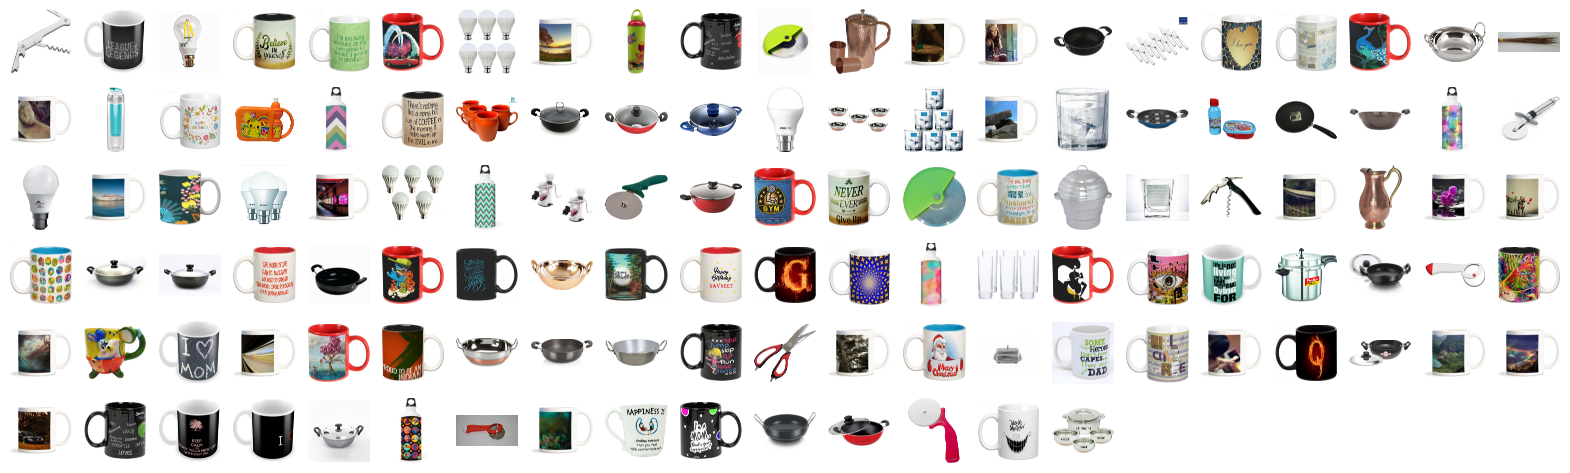


df_test (30 produits):


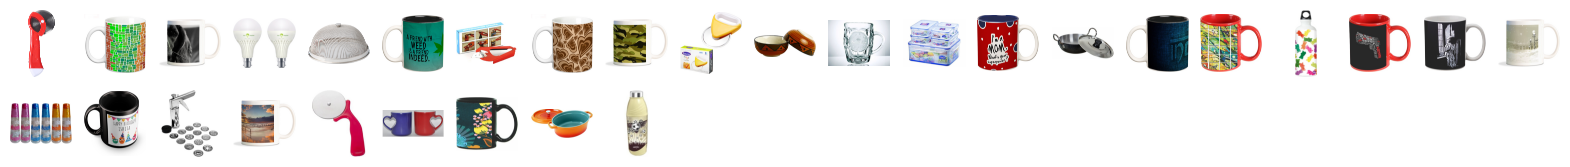

In [18]:
# Affichage des images de la catégorie 'Computers' pour chaque ensemble de données
for df, df_name in [[df_train, 'df_train'], [df_test, 'df_test']]:
    mask = df['label_name'] == 'Kitchen & Dining'
    images = df.loc[mask, 'image'].values
    num_img = len(images)
    print(f"{df_name} ({num_img} produits):")
    plt.figure(figsize=(20, num_img // 7))
    for i in range(num_img):
        plt.subplot(num_img // 7, 21, i + 1)
        filename = image_path + images[i]
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off')
    plt.show()
    print()

### 2.5.3 Vérification des répartitions par catégories

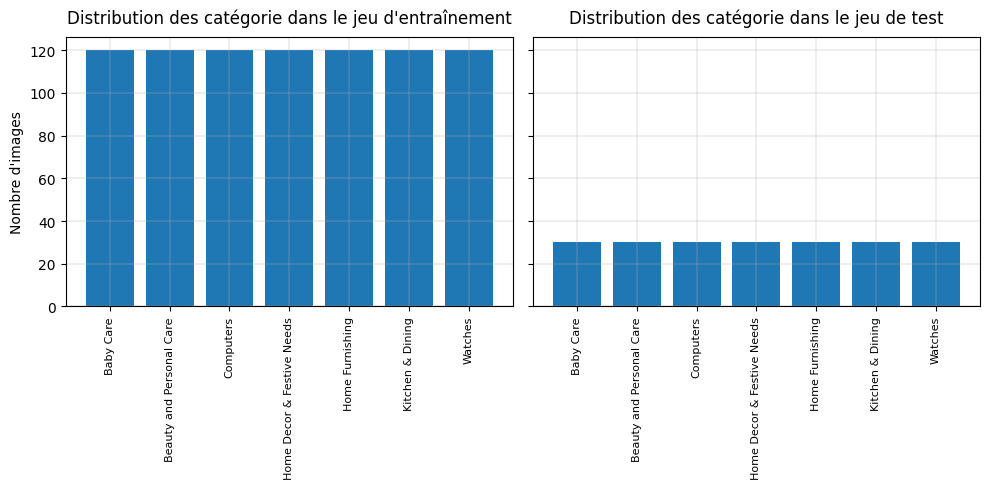

In [19]:
# Distribution des catégorie pour chaque ensemble de données
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
i = 0
for df, set_name, ax in zip([df_train, df_test], 
                            ['jeu d\'entraînement', 'jeu de test'], 
                            axes):
    df_counts = df.groupby('label_name').count().reset_index()
    ax.bar(df_counts['label_name'], df_counts['image'])
    ax.set_title(f"Distribution des catégorie dans le {set_name}", fontsize=12, pad=10)
    ax.set_xticks(df_counts['label_name'])
    ax.set_xticklabels(df_counts['label_name'], fontsize=8, rotation=90)
    ax.grid(linewidth=0.3)
    if i == 0: ax.set_ylabel("Nombre d'images")
    i += 1

plt.tight_layout()
plt.show()

## 2.6 Application du prétraitement

In [20]:
# Application du prétraitement aux données splitées
imag_path = './images'

df_train_images, df_train_labels = preprocess_images(df_train, image_path)
df_test_images, df_test_labels = preprocess_images(df_test, image_path)

In [21]:
# Encodage one-hot des labels
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
df_train_labels = lb.fit_transform(df_train_labels)
df_test_labels = lb.transform(df_test_labels)

In [22]:
# Transformations des labels en vecteurs one-hot (encodage catégoriel)
# num_classes = 7
# df_train_labels = tf.keras.utils.to_categorical(df_train_labels, num_classes)
# df_test_labels = tf.keras.utils.to_categorical(df_test_labels, num_classes)

In [23]:
# Afficher les dimensions après le prétraitement
print("Forme de l'ensemble d'entraînement (images) :", df_train_images.shape)
print("Forme de l'ensemble de test (images) :", df_test_images.shape)
print("Forme de l'ensemble d'entraînement (étiquettes) :", df_train_labels.shape)
print("Forme de l'ensemble de test (étiquettes) :", df_test_labels.shape)

Forme de l'ensemble d'entraînement (images) : (840, 224, 224, 3)
Forme de l'ensemble de test (images) : (210, 224, 224, 3)
Forme de l'ensemble d'entraînement (étiquettes) : (840, 7)
Forme de l'ensemble de test (étiquettes) : (210, 7)


# 3 Réseau de neurones convolutif, sans transfer learning (CNN simple)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input

In [41]:
epochs = 20
batch_size = 32

# Création du modèle CNN
model_cnn = Sequential()

# Input
model_cnn.add(Input(shape=(224, 224, 3)))

# Ajout des couches convolutives
model_cnn.add(Conv2D(32, (3, 3), activation='relu'))
# model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
# model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
# model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D((2, 2)))

# model_cnn.add(Conv2D(256, (3, 3), activation='relu'))
# # model_cnn.add(BatchNormalization())
# model_cnn.add(MaxPooling2D((2, 2)))

# Ajout des couches entièrement connectées
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(7, activation='softmax')) # 7 classes, donc 7 neurones en sortie

# Compilation du modèle
model_cnn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()

# Initialisation de l'arrêt anticipé
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

# Enregistrement du temps de début
start_time = time.perf_counter()

# history_cnn = model_cnn.fit(df_train_images, df_train_labels, epochs=15, validation_split=0.2, callbacks=[early_stopping])
history_cnn = model_cnn.fit(df_train_images, df_train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2, shuffle=True)


# Enregistrement du temps de fin
end_time = time.perf_counter()

# Calculer et afficher le temps écoulé
elapsed_time = end_time - start_time
# print("")
# print(f"Temps écoulé pour l'entraînement: {elapsed_time:.2f} secondes")

# Évaluation du modèle sur l'ensemble de test
test_loss, test_accuracy = model_cnn.evaluate(df_test_images, df_test_labels)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,177,671 (42.64 MB)

 Trainable params: 11,177,671 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 518ms/step - accuracy: 0.1711 - loss: 4.5332 - val_accuracy: 0.0000e+00 - val_loss: 2.1154
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 481ms/step - accuracy: 0.2225 - loss: 1.8912 - val_accuracy: 0.0000e+00 - val_loss: 2.4219
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 475ms/step - accuracy: 0.1876 - loss: 1.8999 - val_accuracy: 0.0000e+00 - val_loss: 2.9216
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 475ms/step - accuracy: 0.2500 - loss: 1.8111 - val_accuracy: 0.0000e+00 - val_loss: 2.7859
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 482ms/step - accuracy: 0.2743 - loss: 1.7966 - val_accuracy: 0.0119 - val_loss: 3.9128
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 496ms/step - accuracy: 0.3069 - loss: 1.6986 - val_accuracy: 0.1071 - val_loss: 2.9354
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 481ms/step - accuracy: 0.4180 - loss: 1.4994 - val_accuracy: 0.0655 - val_loss: 3.1776
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 482ms/step - accuracy: 0.4587 - loss: 1

Précision sur les données de test : 39.05%


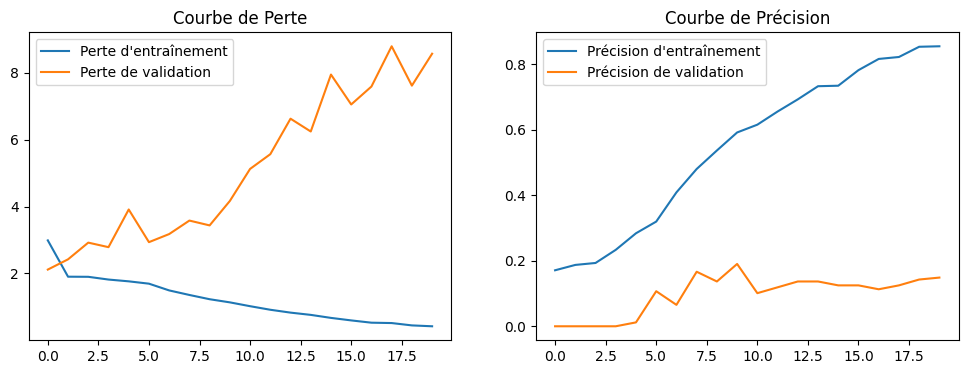

In [42]:
# Afficher la précision du modèle sur les données de test
print(f'Précision sur les données de test : {test_accuracy*100:.2f}%')

# Afficher les courbes d'apprentissage (perte et précision)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Perte d\'entraînement')
plt.plot(history_cnn.history['val_loss'], label='Perte de validation')
plt.legend()
plt.title('Courbe de Perte')

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn.history['val_accuracy'], label='Précision de validation')
plt.legend()
plt.title('Courbe de Précision')

plt.show()

Précision sur les données de test : 41.90%


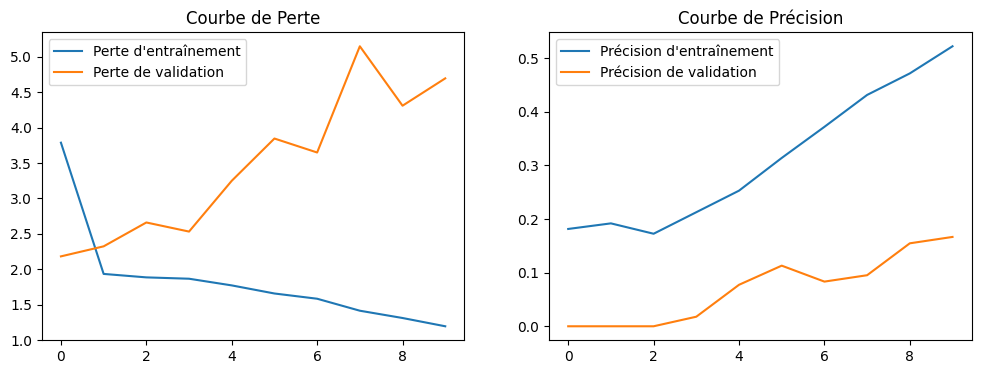

In [38]:
# Afficher la précision du modèle sur les données de test
print(f'Précision sur les données de test : {test_accuracy*100:.2f}%')

# Afficher les courbes d'apprentissage (perte et précision)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Perte d\'entraînement')
plt.plot(history_cnn.history['val_loss'], label='Perte de validation')
plt.legend()
plt.title('Courbe de Perte')

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn.history['val_accuracy'], label='Précision de validation')
plt.legend()
plt.title('Courbe de Précision')

plt.show()

Précision sur les données de test : 40.48%


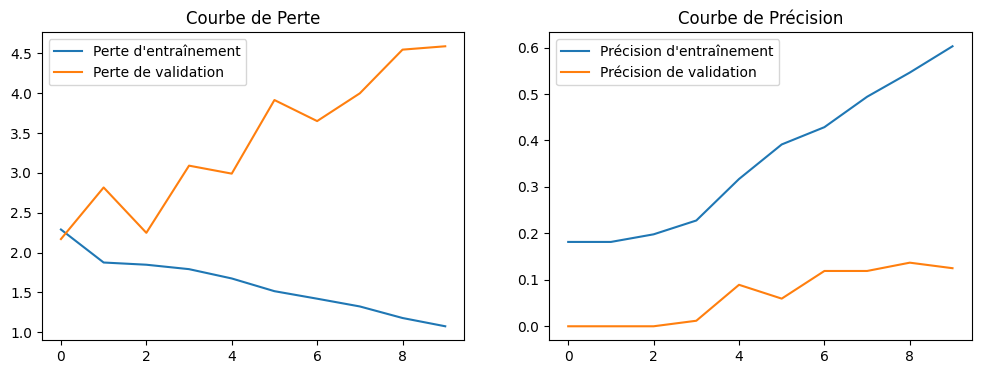

In [36]:
# Afficher la précision du modèle sur les données de test
print(f'Précision sur les données de test : {test_accuracy*100:.2f}%')

# Afficher les courbes d'apprentissage (perte et précision)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Perte d\'entraînement')
plt.plot(history_cnn.history['val_loss'], label='Perte de validation')
plt.legend()
plt.title('Courbe de Perte')

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn.history['val_accuracy'], label='Précision de validation')
plt.legend()
plt.title('Courbe de Précision')

plt.show()

Précision sur les données de test : 44.29%


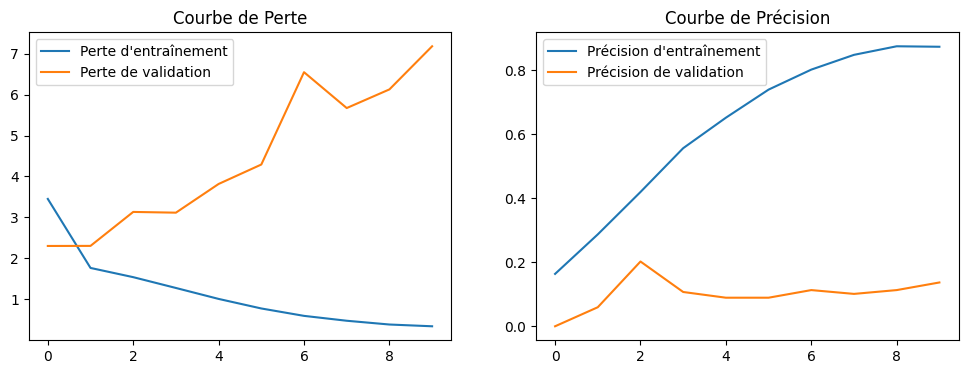

In [34]:
# Afficher la précision du modèle sur les données de test
print(f'Précision sur les données de test : {test_accuracy*100:.2f}%')

# Afficher les courbes d'apprentissage (perte et précision)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Perte d\'entraînement')
plt.plot(history_cnn.history['val_loss'], label='Perte de validation')
plt.legend()
plt.title('Courbe de Perte')

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn.history['val_accuracy'], label='Précision de validation')
plt.legend()
plt.title('Courbe de Précision')

plt.show()

In [ ]:
from tensorflow.keras import layers

In [ ]:
model_cnn = Sequential()
model_cnn.add(Input(shape=(224, 224, 3)))
model_cnn.add(Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(7, activation='softmax'))

model_cnn.summary()

In [ ]:
# Afficher la précision du modèle sur les données de test
print(f'Précision sur les données de test : {test_accuracy*100:.2f}%')

# Afficher les courbes d'apprentissage (perte et précision)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Perte d\'entraînement')
plt.plot(history_cnn.history['val_loss'], label='Perte de validation')
plt.legend()
plt.title('Courbe de Perte')

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn.history['val_accuracy'], label='Précision de validation')
plt.legend()
plt.title('Courbe de Précision')

plt.show()

In [ ]:
# Compiler le modèle avec une fonction de perte, un optimiseur et des métriques
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Entraîner le modèle CNN sur les données d'entraînement
epochs = 20
batch_size = 32

history_cnn = model_cnn.fit(df_train_images, df_train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2, shuffle=True)

# Évaluation du modèle sur les données de test
test_loss, test_accuracy = model_cnn.evaluate(df_test_images, df_test_labels, verbose=2)

In [ ]:
# Afficher la précision du modèle sur les données de test
print(f'Précision sur les données de test : {test_accuracy*100:.2f}%')

# Afficher les courbes d'apprentissage (perte et précision)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Perte d\'entraînement')
plt.plot(history_cnn.history['val_loss'], label='Perte de validation')
plt.legend()
plt.title('Courbe de Perte')

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn.history['val_accuracy'], label='Précision de validation')
plt.legend()
plt.title('Courbe de Précision')

plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Modèle CNN
model_cnn = Sequential()
model_cnn.add(Input(shape=(224, 224, 3)))
model_cnn.add(Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(7, activation='softmax'))

# Compilation du modèle
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Augmentation des données
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(df_train_images)

# Entraînement du modèle avec le générateur de données
history_cnn = model_cnn.fit(datagen.flow(df_train_images, df_train_labels, batch_size=batch_size),
                            epochs=epochs,
                            validation_data=(df_test_images, df_test_labels))

# Évaluation du modèle
test_loss, test_accuracy = model_cnn.evaluate(df_test_images, df_test_labels, verbose=2)
print(f'Précision sur les données de test : {test_accuracy*100:.2f}%')

# Affichage des courbes d'apprentissage
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Perte d\'entraînement')
plt.plot(history_cnn.history['val_loss'], label='Perte de validation')
plt.legend()
plt.title('Courbe de Perte')

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn.history['val_accuracy'], label='Précision de validation')
plt.legend()
plt.title('Courbe de Précision')

plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Modèle CNN
model_cnn = Sequential()
model_cnn.add(Input(shape=(224, 224, 3)))
model_cnn.add(Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(256, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(7, activation='softmax'))

# Compilation du modèle avec RMSprop comme optimiseur
model_cnn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Augmentation des données
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(df_train_images)

# Entraînement du modèle avec le générateur de données
epochs = 20  # Augmentation du nombre d'époques
history_cnn = model_cnn.fit(datagen.flow(df_train_images, df_train_labels, batch_size=batch_size),
                            epochs=epochs,
                            validation_data=(df_test_images, df_test_labels))

# Évaluation du modèle
test_loss, test_accuracy = model_cnn.evaluate(df_test_images, df_test_labels, verbose=2)
print(f'Précision sur les données de test : {test_accuracy*100:.2f}%')

# Affichage des courbes d'apprentissage
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Perte d\'entraînement')
plt.plot(history_cnn.history['val_loss'], label='Perte de validation')
plt.legend()
plt.title('Courbe de Perte')

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn.history['val_accuracy'], label='Précision de validation')
plt.legend()
plt.title('Courbe de Précision')

plt.show()


In [ ]:
# Afficher la précision du modèle sur les données de test
print(f'Précision sur les données de test : {test_accuracy*100:.2f}%')

# Afficher les courbes d'apprentissage (perte et précision)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Perte d\'entraînement')
plt.plot(history_cnn.history['val_loss'], label='Perte de validation')
plt.legend()
plt.title('Courbe de Perte')

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn.history['val_accuracy'], label='Précision de validation')
plt.legend()
plt.title('Courbe de Précision')

plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Modèle CNN
model_cnn = Sequential()
model_cnn.add(Input(shape=(224, 224, 3)))
model_cnn.add(Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(7, activation='softmax'))

# Compilation du modèle
model_cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Augmentation des données
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(df_train_images)

# Entraînement du modèle avec le générateur de données
epochs = 20
batch_size = 32
history_cnn = model_cnn.fit(datagen.flow(df_train_images, df_train_labels, batch_size=batch_size),
                            epochs=epochs,
                            validation_data=(df_test_images, df_test_labels))

# Évaluation du modèle
test_loss, test_accuracy = model_cnn.evaluate(df_test_images, df_test_labels, verbose=2)
print(f'Précision sur les données de test : {test_accuracy*100:.2f}%')

# Affichage des courbes d'apprentissage
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Perte d\'entraînement')
plt.plot(history_cnn.history['val_loss'], label='Perte de validation')
plt.legend()
plt.title('Courbe de Perte')

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn.history['val_accuracy'], label='Précision de validation')
plt.legend()
plt.title('Courbe de Précision')

plt.show()


# 3 Pré-traitement des images

Avant de procéder à un pré-traitement global, chaque étape est détaillée pour une image

* Fonction d'affichage d'un histogramme

In [ ]:
def plot_histogram(image):
    color = ('r', 'g', 'b')
    for i, col in enumerate(color):
        histogram = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(histogram, color = col)
    plt.title('Histogramme')
    plt.xlim([0, 256])
    plt.show()

## 3.1 Pré-traitement d'une image

### 3.1.1 Chargement et affichage d'une image originale

In [ ]:
# Récupération du nom de fichier d'une image
image_file = df_datas['image'].sample(1).values[0]
# image_file = df_datas.iloc[859]['image']

# Affichage
image = cv2.imread(images_path + image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title('Image originale')
plt.show()

### 3.1.2 Redimensionnement 256 x 256

In [ ]:
# Redimensionnement
image_resized = cv2.resize(image, (256, 256))
plt.imshow(image_resized)
plt.title('256 x 256')
plt.show()

### 3.1.3 Filtrage de bruit

In [ ]:
# Filtrage de bruit
image_filtered = cv2.GaussianBlur(image_resized, (5, 5), 0)
plt.imshow(image_filtered)
plt.title('Filtre bruit')
plt.show()

### 3.1.4 Conversion en niveau de gris

In [ ]:
# Conversion en niveaux de gris
image_gray = cv2.cvtColor(image_filtered, cv2.COLOR_RGB2GRAY)
plt.imshow(image_gray, cmap='gray')
plt.title('Niveaux de gris')
plt.show()

### 3.1.5 Equalisation

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
image_equalized = cv2.equalizeHist(image_gray)
plt.imshow(image_equalized, cmap='gray')
plt.title('Equalisation')
plt.show()

### 3.1.6 Récupération et affichage des descripteurs SIFT

In [ ]:
keypoints, descriptors = sift.detectAndCompute(image_equalized, None)
img = cv2.drawKeypoints(image_equalized, keypoints, image_equalized)
plt.imshow(img)
plt.title('Descripteurs')
plt.show()

print("Descripteurs : ", descriptors.shape)
print()
print(descriptors)

## 3.2 Pré-traitement de toutes les images

### 3.2.1 Récupération des descripteurs

In [ ]:
num_images = df_datas.shape[0]

sift_keypoints = []
sift_descriptors = []

start_sift = time.perf_counter()
sift = cv2.xfeatures2d.SIFT_create()

print('Pré-traitement des images', end='')
for image_number, image_filename in enumerate(df_datas['image'].values):
    if image_number % 25 == 0: print('.', end='')

    # Chargement image
    image = cv2.imread(images_path + image_filename)

    # Pré-traitement
    image = cv2.resize(image, (256, 256)) # Redimensionnement
    image = cv2.GaussianBlur(image, (5, 5), 0) # Filtre bruit
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Nuances de gris
    image = cv2.equalizeHist(image) # Equalisation (contraste)

    # Récupération des descripteurs
    keypoints, descriptors = sift.detectAndCompute(image, None)

    if descriptors is None:
        print(f"L'image {i} ({filename}) n'a pas de descripteurs !")
        
    # Nombre de descripteurs pour chaque image
    sift_keypoints.append(len(keypoints))

    # Sauvegarde des descripteurs
    if image_number == 0:
        descriptors_array = np.asarray(descriptors)
    else:
        descriptors_array = np.concatenate([descriptors_array, np.asarray(descriptors)], axis=0)
    
end_sift = time.perf_counter()
sift_duration = end_sift - start_sift

print(f'\nDurée de traitement : {sift_duration:.2f} secondes')

### 3.2.2 Création des clusters de descripteurs

* Création des cluster par segmentation de tous les descripteurs, quelle que soit l'image à laquelle ils appartiennent  
* Utilisation de MiniBatchKMeans pour optimiser les temps de traitement  
* Nombre de clusters fixé à la racine carrée du nombre de descripteurs  

In [ ]:
start_kmeans = time.perf_counter()

# Nombre de clusters
# n_clusters = int(round(np.sqrt(len(descriptors_array)), 0))
n_clusters = 100

# Création des clusters
kmeans = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', random_state=0)
kmeans.fit(descriptors_array)

end_kmeans = time.perf_counter()
kmeans_duration = end_kmeans - start_kmeans

print(f'\nNombre de clusters de descripteurs : {n_clusters}')
print(f'Durée de traitement : {kmeans_duration:.2f} secondes')

### 2.3.3 Création des features

* Features d'une image = fréquences des descripteurs de l'image dans chaque cluster, pondérées par le nombre de descripteurs de l'image (histogramme)

In [ ]:
# Fonction de création d'un histogramme
def build_histogram(kmeans_model, descriptors, image_id):
    number_of_descriptors = len(descriptors)
    if number_of_descriptors == 0: print(f"\nAucun descripteur pour l'image {image_id}")
    labels = kmeans_model.predict(descriptors)
    histogram = np.zeros(len(kmeans_model.cluster_centers_))
    for label in labels:
        histogram[label] += 1.0 / number_of_descriptors
    return histogram

In [ ]:
start_fc = time.perf_counter()

# Création d'une matrice d'histogrammes
histograms = []

last_index = 0
print("Création des histogrammes", end='')
for image_number in range(len(sift_keypoints)):
    if image_number % 25 == 0: print('.', end='')
    number_of_keypoints = sift_keypoints[image_number]
    start_index, last_index = last_index, last_index + number_of_keypoints
    descriptors = descriptors_array[start_index:last_index]
    histogram = build_histogram(kmeans, descriptors, image_number)
    histograms.append(histogram)
print()

end_fc = time.perf_counter()
fc_duration = end_fc - start_fc
print(f'Durée de traitement : {fc_duration:.2f} secondes')

# 4 Analyse visuelle

## 4.1 Réductions de dimension

### 4.1.1 Réduction de dimension via PCA

* L'ACP permet de créer des features décorrélées entre elles et de diminuer leur dimension, tout en gardant un pourcentage d'explication de la variance élevée (avec `n_components=0.99`)
* Elle permet une meilleure séparation des données pour la réduction de dimension via t-SNE à suivre

In [ ]:
# Conversion des features sous forme d'un arrat numpy
histograms_array = np.asarray(histograms)

print(f"Dimension du dataset avant PCA : {histograms_array.shape}")
pca = PCA(n_components=0.99)
pca_features = pca.fit_transform(histograms_array)
print(f"Dimension du dataset après réduction PCA : {pca_features.shape}")

### 4.1.2 Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes t-SNE pour affichage en 2D de la représentation des images

In [ ]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=2000,
    init='random',
    random_state=0
)

X_tsne = tsne.fit_transform(pca_features)
# X_tsne = tsne.fit_transform(histograms_array)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne 1', 'tsne 2'])
df_tsne["Catégorie"] = df_datas["label_name"]

* Création de clusters KMeans

In [ ]:
kmeans = KMeans(n_clusters=7, init='k-means++', random_state=0)
kmeans.fit(X_tsne)

df_tsne['Cluster'] = kmeans.labels_

## 4.2 Visualisations

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

for i, criteria in enumerate(('Catégorie', 'Cluster')):
    sns.scatterplot(data=df_tsne, x='tsne 1', y='tsne 2', hue=criteria, palette='bright', alpha=0.6, ax=ax[i])
    ax[i].set_title(f"{criteria}s - TSNE", fontweight='bold', pad=10)
    ax[i].set_xlabel('tsne 1', fontweight = 'bold')
    ax[i].set_ylabel('tsne 2', fontweight = 'bold')

plt.show()

* Les catégories ne sont pas séparées  
* Les produits ne se regroupent pas, seuls les produits de la catégorie 'Watches' semblent légèrement plus nombreux dans le cluster 6...
* L'analyse visuelle ne confirme pas une faisabilité de classification via SIFT

# 5 Analyse métriques

* Le très faible score ARI de 0.05 confirme l'analyse visuelle

In [ ]:
ari_score = adjusted_rand_score(df_datas['label'], kmeans.labels_)
print(f"Score ARI : {round(ari_score, 3)}")

* Une matrice de confusion n'aurait pas de sens puisqu'il est impossible de rattacher les catégories aux clusters de manière relativement fiable

* Enregistement des métriques

In [ ]:
# Chargement du fichier
df_metrics = pd.read_csv('df_metrics.csv')

In [ ]:
# Suppression de la ligne SIFT si elle existe
mask = df_metrics['Modèle'] != 'SIFT'
df_metrics = df_metrics.loc[mask]

# Ajout des métriques SIFT
new_row = pd.DataFrame({
    'Modèle': ['SIFT'],
    'Méthode de réduction de dimensions': ['t-SNE'],
    'Score ARI': [ari_score],
    'Durée totale': [f"{np.round(sift_duration + kmeans_duration + fc_duration, 2)} secs"],
    'Durée de prétraitement': [f"{np.round(sift_duration + kmeans_duration, 2)} secs"],
    'Durée d\'extraction des features': [f"{np.round(fc_duration, 2)} secs"],
    'Accuracy': ['-']
})
df_metrics = pd.concat([df_metrics, new_row], ignore_index=True)    

In [ ]:
# Vérification
display(df_metrics.sort_values('Score ARI', ascending=False))

In [ ]:
# Enregistrement du fichier csv
df_metrics.to_csv('df_metrics.csv', index=False)